**AUDU-DJELLAS Transfer Learning**

In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.client import device_lib

sns.set()

import warnings

warnings.filterwarnings("ignore")

In [2]:
print("--- TEST de présence de CUDA ---")
tensorflow_with_cuda = tf.test.is_built_with_cuda()
print("CUDA dans Tensorflow : " + str(tensorflow_with_cuda))
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

--- TEST de présence de CUDA ---
CUDA dans Tensorflow : False
[]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10728723246538500523
xla_global_id: -1
]


In [3]:
pizza_dir = './pizza-not-pizza/pizza'
not_pizza_dir = './pizza-not-pizza/not_pizza'
data_dir = './pizza-not-pizza'

In [4]:
epoch = 7

In [5]:
num_pizza_images = len(os.listdir(pizza_dir))
non_pizza_images = len(os.listdir(not_pizza_dir))
print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')

Number of Pizza images: 983
Number of Non-Pizza images: 983


In [6]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255., validation_split=0.1)

train_data = data_gen.flow_from_directory(data_dir,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          subset='training',
                                          class_mode='binary')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size=(224, 224),
                                        batch_size=32,
                                        subset='validation',
                                        class_mode='binary')

Found 1770 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [7]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax1 = sns.lineplot(x=epochs, y=loss, label='Training Loss', ax=ax[0])
    ax1 = sns.lineplot(x=epochs, y=val_loss, label='Test Loss', ax=ax[0])
    ax1.set(title='Loss', xlabel='Epochs')

    ax2 = sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy', ax=ax[1])
    ax2 = sns.lineplot(x=epochs, y=val_accuracy, label='Test Accuracy', ax=ax[1])
    ax2.set(title='Accuracy', xlabel='Epochs')

## PMC
On va essayer de construire un PCM capable de différencier des pizzas avec des "non-pizzas"

Epoch 1/7
56/56 [==============================] - 27s 470ms/step - loss: 11.9193 - accuracy: 0.5904 - val_loss: 2.8121 - val_accuracy: 0.5969
Epoch 2/7
56/56 [==============================] - 25s 451ms/step - loss: 2.8583 - accuracy: 0.6254 - val_loss: 3.1093 - val_accuracy: 0.5510
Epoch 3/7
56/56 [==============================] - 25s 451ms/step - loss: 1.1159 - accuracy: 0.7226 - val_loss: 1.4719 - val_accuracy: 0.6582
Epoch 4/7
56/56 [==============================] - 25s 452ms/step - loss: 1.0182 - accuracy: 0.7305 - val_loss: 1.1524 - val_accuracy: 0.6888
Epoch 5/7
56/56 [==============================] - 25s 451ms/step - loss: 0.6478 - accuracy: 0.8056 - val_loss: 1.0973 - val_accuracy: 0.6684
Epoch 6/7
56/56 [==============================] - 25s 453ms/step - loss: 0.4349 - accuracy: 0.8395 - val_loss: 2.7483 - val_accuracy: 0.5663
Epoch 7/7
56/56 [==============================] - 26s 458ms/step - loss: 0.3679 - accuracy: 0.8672 - val_loss: 1.2052 - val_accuracy: 0.6888


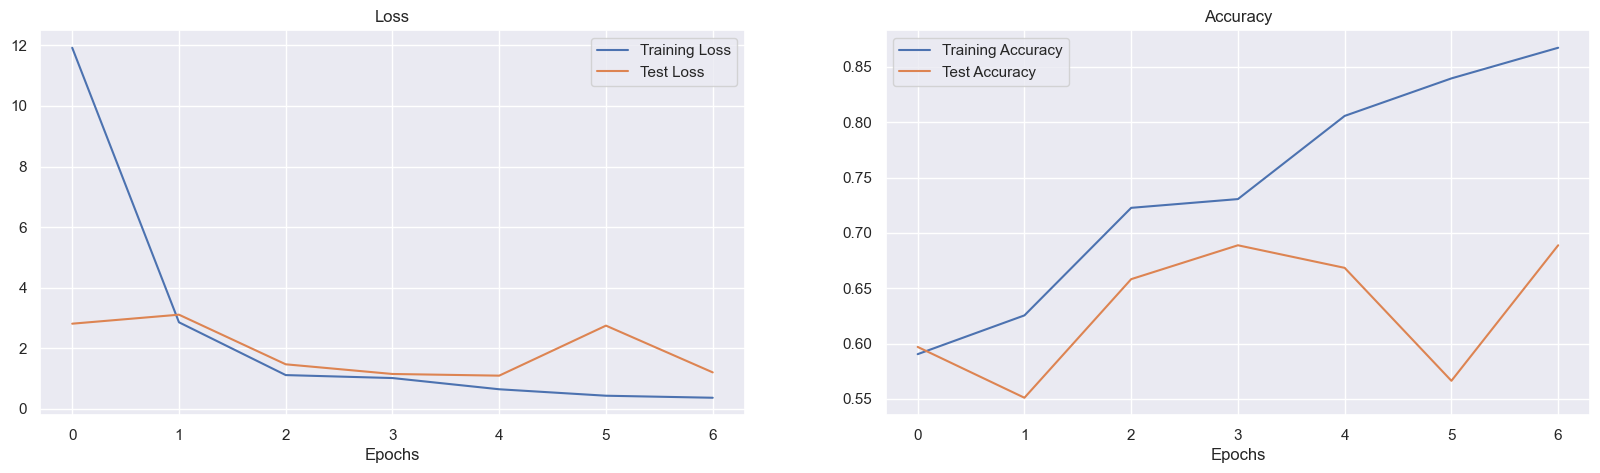

In [8]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input layer
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])
model_1.save_weights('model1_init.h5')

model_1.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs=epoch,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))
plot_loss_curves(history_1)

On remarque un surapprentissage avec un Training à 85% et un test à seulement 70%

## CNN

### Convolation sans couche cache

Epoch 1/7
56/56 [==============================] - 27s 469ms/step - loss: 0.6732 - accuracy: 0.5983 - val_loss: 0.6054 - val_accuracy: 0.6684
Epoch 2/7
56/56 [==============================] - 26s 457ms/step - loss: 0.5572 - accuracy: 0.7113 - val_loss: 0.5491 - val_accuracy: 0.7347
Epoch 3/7
56/56 [==============================] - 27s 478ms/step - loss: 0.5060 - accuracy: 0.7695 - val_loss: 0.5596 - val_accuracy: 0.7041
Epoch 4/7
56/56 [==============================] - 27s 475ms/step - loss: 0.3917 - accuracy: 0.8429 - val_loss: 0.6984 - val_accuracy: 0.6633
Epoch 5/7
56/56 [==============================] - 27s 477ms/step - loss: 0.3187 - accuracy: 0.8780 - val_loss: 0.5634 - val_accuracy: 0.7653
Epoch 6/7
56/56 [==============================] - 26s 469ms/step - loss: 0.2244 - accuracy: 0.9249 - val_loss: 0.6551 - val_accuracy: 0.6939
Epoch 7/7
56/56 [==============================] - 27s 484ms/step - loss: 0.1997 - accuracy: 0.9350 - val_loss: 0.6349 - val_accuracy: 0.7092


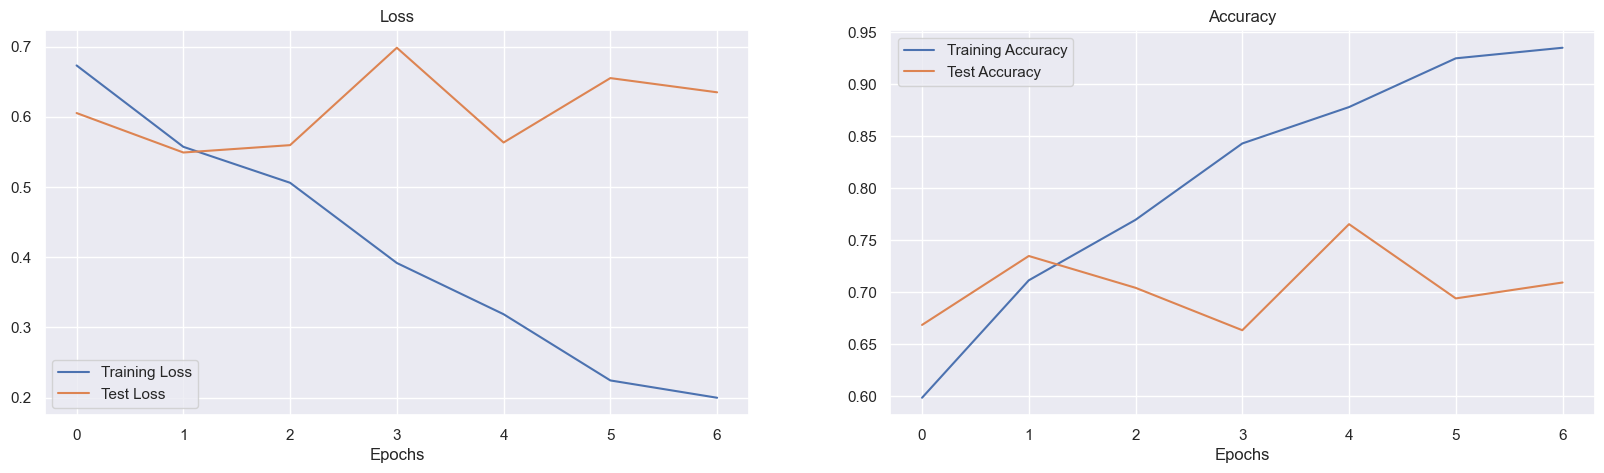

In [9]:
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model_2.save_weights('model2_init.h5')

model_2.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs=epoch,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))
plot_loss_curves(history_2)

On remarque avec un convolution un surapprentissage moins important ainsi qu'un pourcentage de réussite plus important sur la validation.

### Convolution avec couche cache

Epoch 1/7
56/56 [==============================] - 27s 467ms/step - loss: 0.6214 - accuracy: 0.6655 - val_loss: 0.6269 - val_accuracy: 0.6633
Epoch 2/7
56/56 [==============================] - 26s 462ms/step - loss: 0.5499 - accuracy: 0.7226 - val_loss: 0.5384 - val_accuracy: 0.7500
Epoch 3/7
56/56 [==============================] - 26s 458ms/step - loss: 0.5273 - accuracy: 0.7446 - val_loss: 0.5154 - val_accuracy: 0.7551
Epoch 4/7
56/56 [==============================] - 26s 456ms/step - loss: 0.4861 - accuracy: 0.7751 - val_loss: 0.5214 - val_accuracy: 0.7755
Epoch 5/7
56/56 [==============================] - 26s 463ms/step - loss: 0.4326 - accuracy: 0.8192 - val_loss: 0.6270 - val_accuracy: 0.6837
Epoch 6/7
56/56 [==============================] - 26s 460ms/step - loss: 0.3939 - accuracy: 0.8469 - val_loss: 0.5048 - val_accuracy: 0.7449
Epoch 7/7
56/56 [==============================] - 26s 462ms/step - loss: 0.2812 - accuracy: 0.8966 - val_loss: 0.5596 - val_accuracy: 0.7602


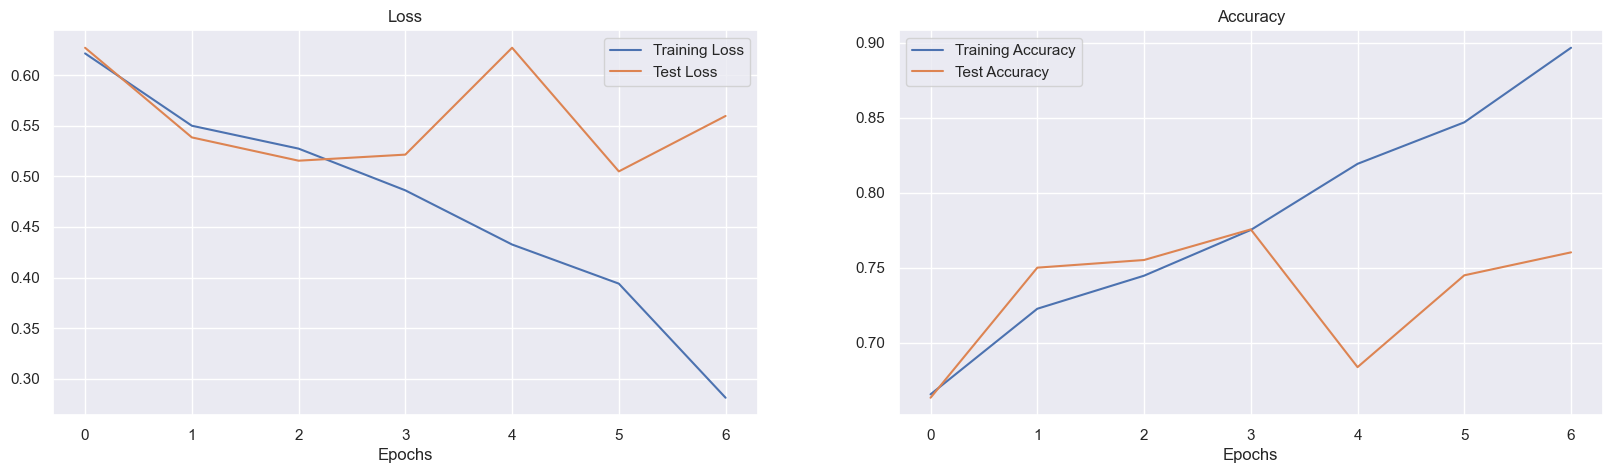

In [10]:
model_3 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model_3.save_weights('model3_init.h5')

model_3.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_3 = model_3.fit(train_data,
                        epochs=epoch,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))
plot_loss_curves(history_3)

Ici, une couche caché ne nous apporte pas grand chose

## Data Augmentation

In [11]:
# Defining data generator with Data Augmentation
data_gen_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255.,
                                                                     zoom_range=0.2,
                                                                     shear_range=0.2,
                                                                     horizontal_flip=True,
                                                                     rotation_range=20,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     fill_mode='nearest')

print('Augmented training Images:')
train_data_augmented = data_gen_augmented.flow_from_directory(data_dir,
                                                              target_size=(224, 224),
                                                              batch_size=32,
                                                              subset='training',
                                                              class_mode='binary')

print('Unchanged Validation Images:')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size=(224, 224),
                                        batch_size=32,
                                        subset='validation',
                                        class_mode='binary')

Augmented training Images:
Found 1966 images belonging to 2 classes.
Unchanged Validation Images:
Found 196 images belonging to 2 classes.


### PMC

Epoch 1/7
62/62 [==============================] - 32s 502ms/step - loss: 7.9663 - accuracy: 0.5666 - val_loss: 2.8164 - val_accuracy: 0.6071
Epoch 2/7
62/62 [==============================] - 31s 503ms/step - loss: 2.2079 - accuracy: 0.5961 - val_loss: 2.2818 - val_accuracy: 0.5816
Epoch 3/7
62/62 [==============================] - 31s 500ms/step - loss: 2.9778 - accuracy: 0.5982 - val_loss: 1.1497 - val_accuracy: 0.6786
Epoch 4/7
62/62 [==============================] - 32s 512ms/step - loss: 1.7187 - accuracy: 0.5951 - val_loss: 1.6457 - val_accuracy: 0.6327
Epoch 5/7
62/62 [==============================] - 31s 505ms/step - loss: 1.5145 - accuracy: 0.6104 - val_loss: 1.0082 - val_accuracy: 0.6480
Epoch 6/7
62/62 [==============================] - 32s 522ms/step - loss: 1.2807 - accuracy: 0.6002 - val_loss: 0.9031 - val_accuracy: 0.6582
Epoch 7/7
62/62 [==============================] - 32s 520ms/step - loss: 0.8449 - accuracy: 0.6384 - val_loss: 0.6607 - val_accuracy: 0.7092
Le pre

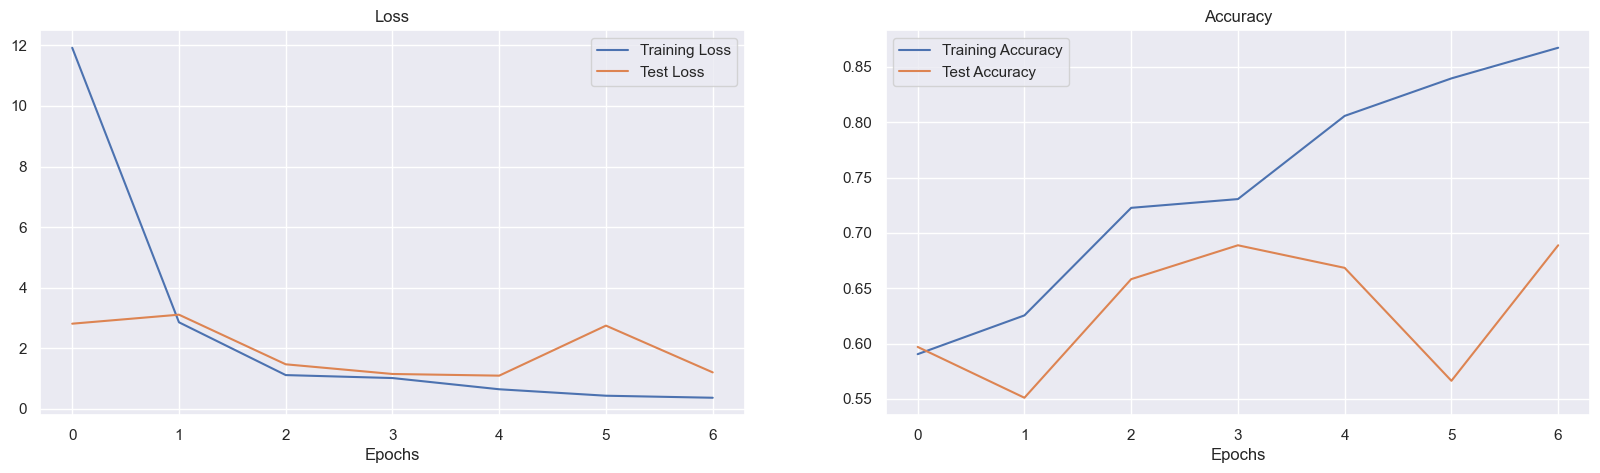

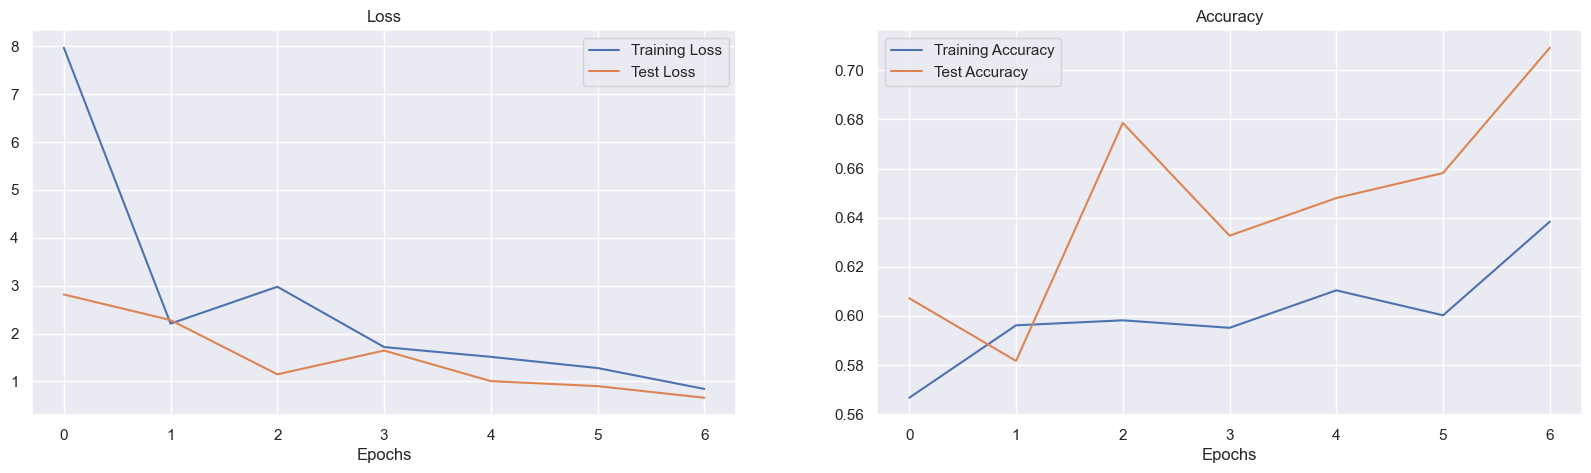

In [12]:
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input layer
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])
model_1.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_1_1 = model_1.fit(train_data_augmented,
                          epochs=epoch,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=val_data,
                          validation_steps=len(val_data))
print("Le premier graphique correspond aux données normales, le second au données augmentées")
plot_loss_curves(history_1)
plot_loss_curves(history_1_1)

### CNN sans couche

Epoch 1/7
62/62 [==============================] - 32s 500ms/step - loss: 0.7869 - accuracy: 0.5361 - val_loss: 0.6250 - val_accuracy: 0.7449
Epoch 2/7
62/62 [==============================] - 33s 526ms/step - loss: 0.6403 - accuracy: 0.6389 - val_loss: 0.6370 - val_accuracy: 0.6429
Epoch 3/7
62/62 [==============================] - 31s 496ms/step - loss: 0.6120 - accuracy: 0.6673 - val_loss: 0.5914 - val_accuracy: 0.7143
Epoch 4/7
62/62 [==============================] - 31s 493ms/step - loss: 0.5977 - accuracy: 0.6750 - val_loss: 0.5223 - val_accuracy: 0.7755
Epoch 5/7
62/62 [==============================] - 31s 492ms/step - loss: 0.5831 - accuracy: 0.6953 - val_loss: 0.5994 - val_accuracy: 0.7245
Epoch 6/7
62/62 [==============================] - 31s 492ms/step - loss: 0.5839 - accuracy: 0.7019 - val_loss: 0.6253 - val_accuracy: 0.6224
Epoch 7/7
62/62 [==============================] - 31s 493ms/step - loss: 0.5885 - accuracy: 0.6887 - val_loss: 0.5051 - val_accuracy: 0.7908
Le pre

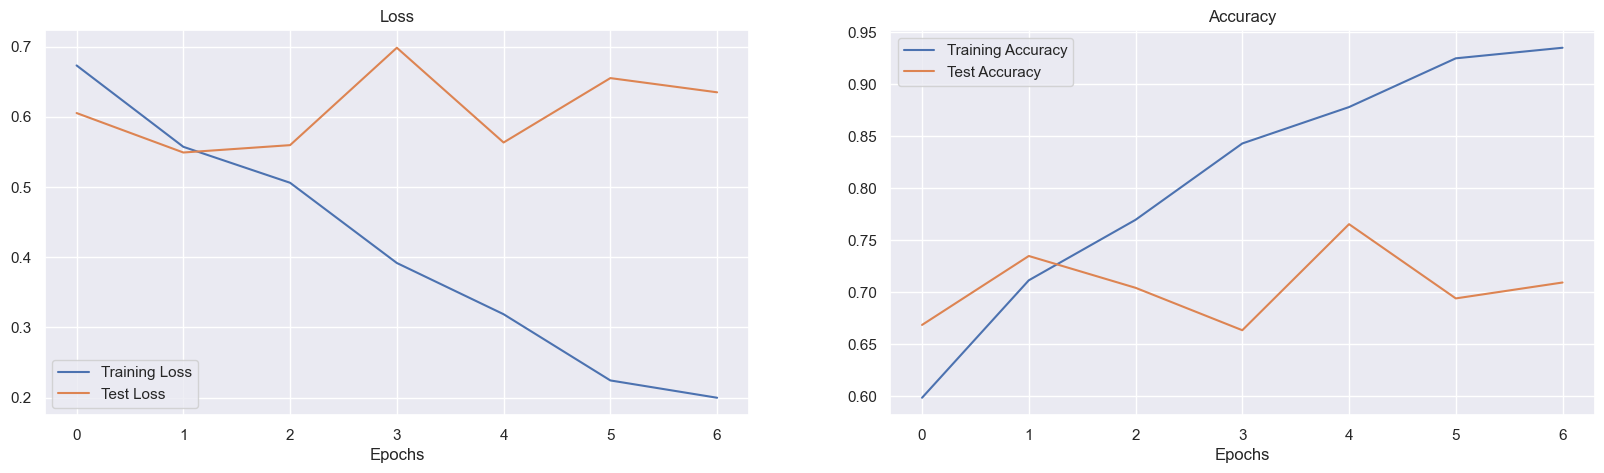

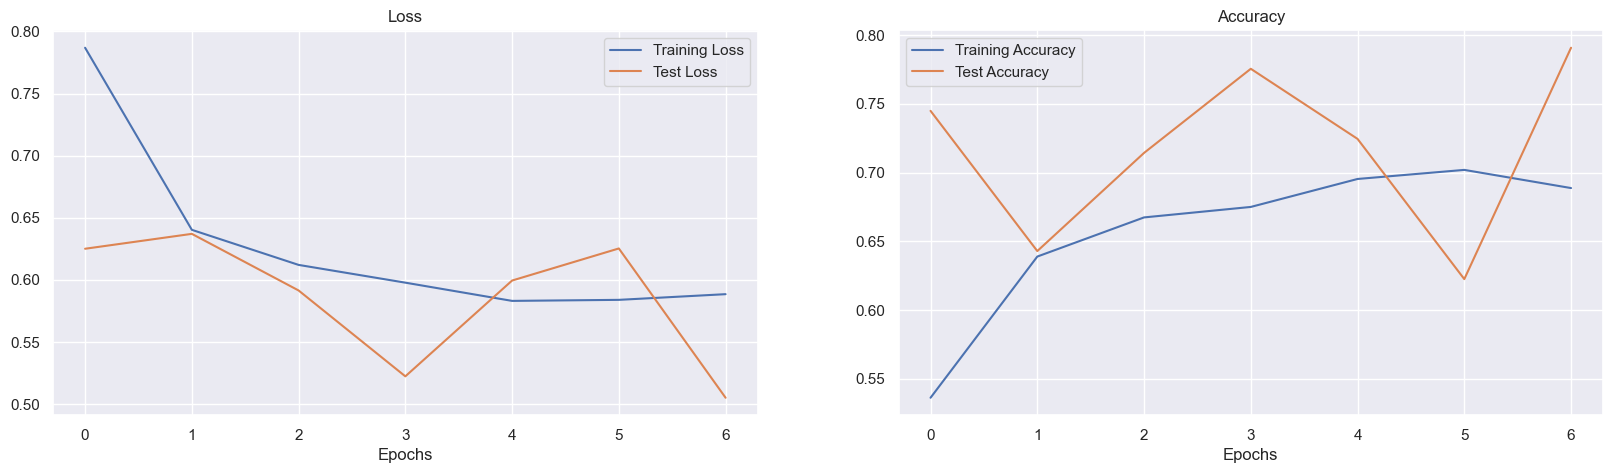

In [13]:
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])
model_2.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_2_1 = model_2.fit(train_data_augmented,
                          epochs=epoch,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=val_data,
                          validation_steps=len(val_data))

print("Le premier graphique correspond aux données normales, le second au données augmentées")
plot_loss_curves(history_2)
plot_loss_curves(history_2_1)

### CNN avec couche

Epoch 1/7
62/62 [==============================] - 32s 508ms/step - loss: 0.7326 - accuracy: 0.5290 - val_loss: 0.6596 - val_accuracy: 0.6786
Epoch 2/7
62/62 [==============================] - 32s 521ms/step - loss: 0.6463 - accuracy: 0.6312 - val_loss: 0.6489 - val_accuracy: 0.6327
Epoch 3/7
62/62 [==============================] - 32s 513ms/step - loss: 0.6302 - accuracy: 0.6450 - val_loss: 0.5950 - val_accuracy: 0.7296
Epoch 4/7
62/62 [==============================] - 32s 513ms/step - loss: 0.6299 - accuracy: 0.6587 - val_loss: 0.5768 - val_accuracy: 0.7347
Epoch 5/7
62/62 [==============================] - 33s 537ms/step - loss: 0.5921 - accuracy: 0.6841 - val_loss: 0.7021 - val_accuracy: 0.5459
Epoch 6/7
62/62 [==============================] - 33s 534ms/step - loss: 0.6043 - accuracy: 0.6734 - val_loss: 0.5664 - val_accuracy: 0.7245
Epoch 7/7
62/62 [==============================] - 33s 529ms/step - loss: 0.5786 - accuracy: 0.7030 - val_loss: 0.5294 - val_accuracy: 0.7449
Le pre

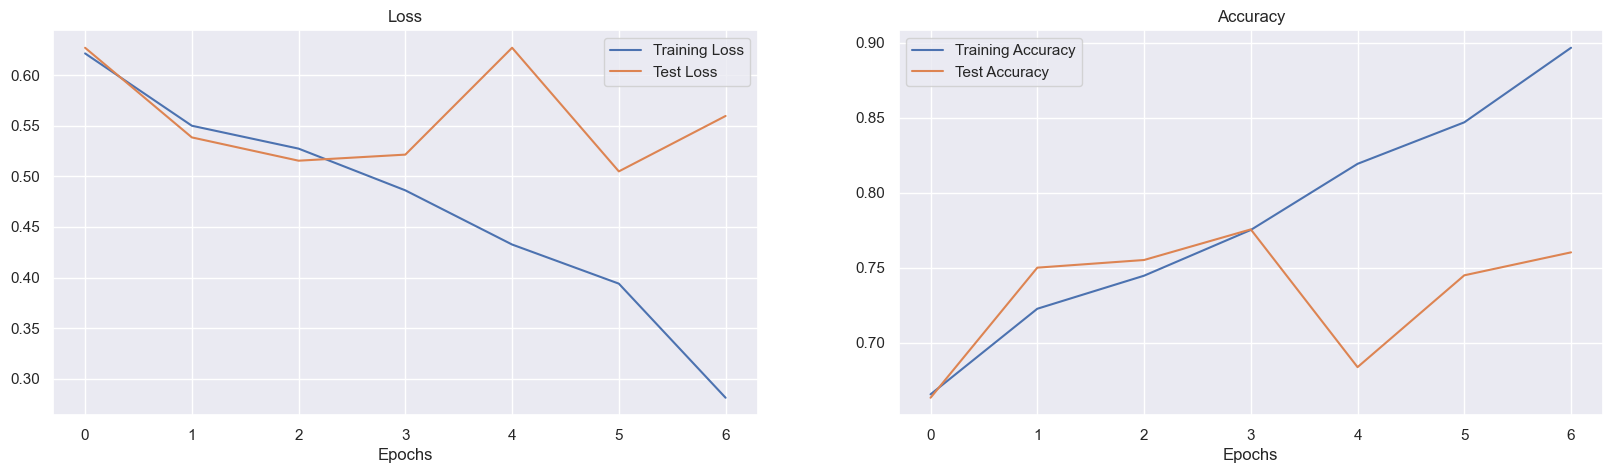

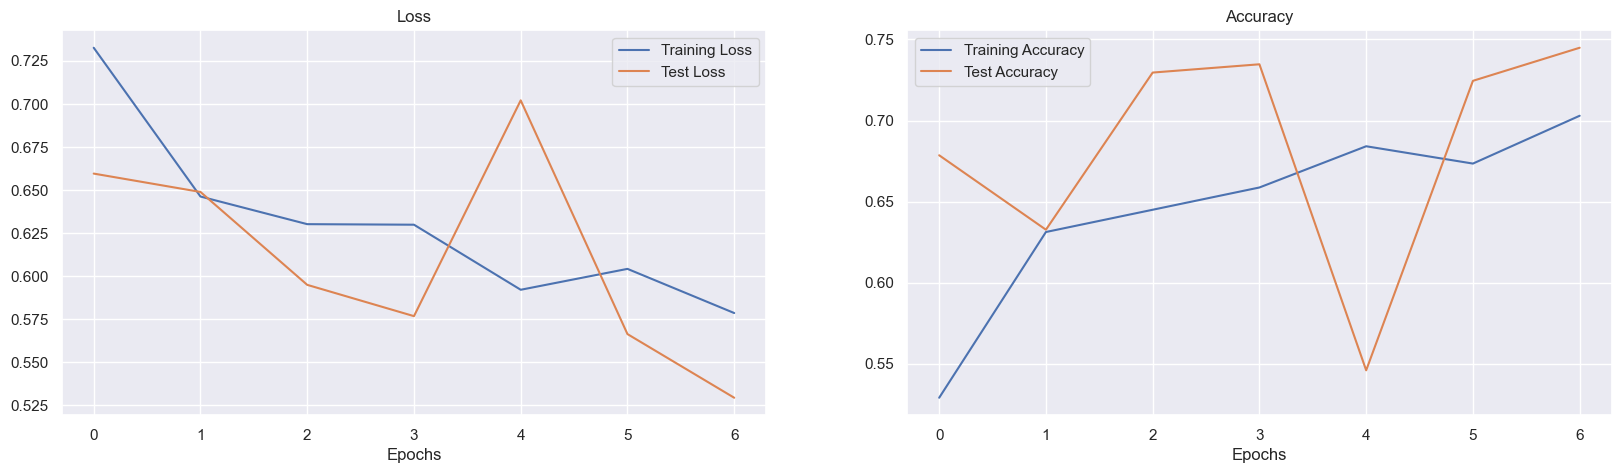

In [14]:
model_3 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])
model_3.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_3_1 = model_3.fit(train_data_augmented,
                          epochs=epoch,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=val_data,
                          validation_steps=len(val_data))
print("Le premier graphique correspond aux données normales, le second au données augmentées")
plot_loss_curves(history_3)
plot_loss_curves(history_3_1)

On remarque que même avec des techniques comme le Data Augmentation ou avec des modèles variés, on obtient des résultats décevants ainsi qu'un sur-apprentissage.

## Transfer Learning

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/3
56/56 [==============================] - 311s 5s/step - loss: 0.2565 - accuracy: 0.9164 - val_loss: 0.1581 - val_accuracy: 0.9439
Epoch 2/3
56/56 [==============================] - 297s 5s/step - loss: 0.1180 - accuracy: 0.9605 - val_loss: 0.1405 - val_accuracy: 0.9541
Epoch 3/3
56/56 [==============================] - 299s 5s/step - loss: 0.0990 - accuracy: 0.9650 - val_loss: 0.1278 - val_accuracy: 0.9490


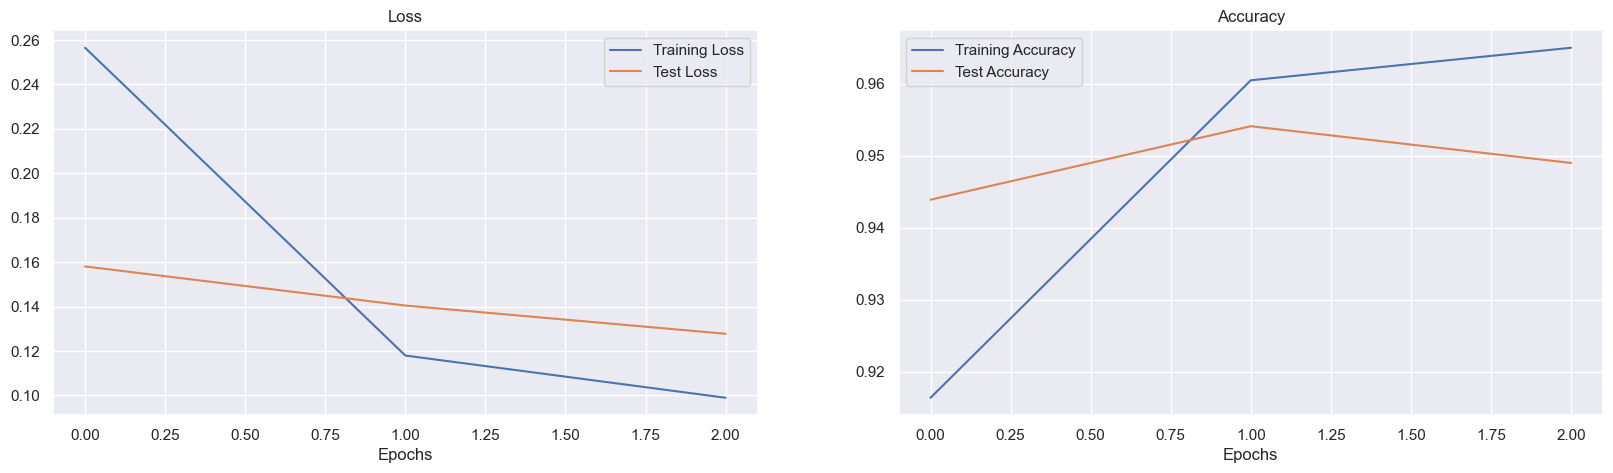

In [15]:
url = 'https://tfhub.dev/google/efficientnet/b7/feature-vector/1'

feature_extractor_layer = hub.KerasLayer(url,
                                         trainable=False,
                                         input_shape=(224, 224, 3))

model_vgg = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(loss=tf.losses.BinaryCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])

history_vgg = model_vgg.fit(train_data,
                            epochs=3,
                            steps_per_epoch=len(train_data),
                            validation_data=val_data,
                            validation_steps=len(val_data))
plot_loss_curves(history_vgg)


## Inception

Epoch 1/12
50/50 [==============================] - 15s 256ms/step - loss: 0.8892 - accuracy: 0.7637 - val_loss: 0.1491 - val_accuracy: 0.9286
Epoch 2/12
50/50 [==============================] - 12s 246ms/step - loss: 0.4627 - accuracy: 0.8615 - val_loss: 0.1769 - val_accuracy: 0.9337
Epoch 3/12
50/50 [==============================] - 12s 248ms/step - loss: 0.3033 - accuracy: 0.8926 - val_loss: 0.2859 - val_accuracy: 0.9031
Epoch 4/12
50/50 [==============================] - 12s 247ms/step - loss: 0.2530 - accuracy: 0.9104 - val_loss: 0.3600 - val_accuracy: 0.8827
Epoch 5/12
50/50 [==============================] - 13s 250ms/step - loss: 0.2264 - accuracy: 0.9136 - val_loss: 0.1616 - val_accuracy: 0.9490
Epoch 6/12
50/50 [==============================] - 13s 254ms/step - loss: 0.2386 - accuracy: 0.9149 - val_loss: 0.3996 - val_accuracy: 0.8418
Epoch 7/12
50/50 [==============================] - 13s 249ms/step - loss: 0.2195 - accuracy: 0.9276 - val_loss: 0.3806 - val_accuracy: 0.8776

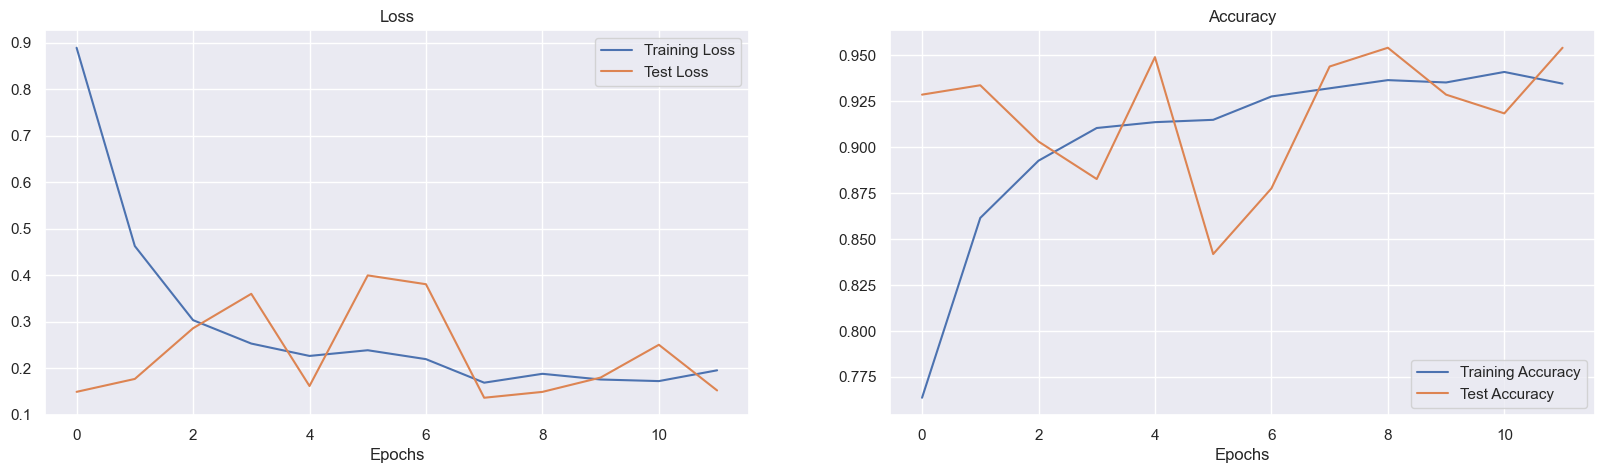

In [26]:

from keras.optimizers import RMSprop
from keras import Model
from keras.applications import InceptionV3
from keras import layers

resnet_pretrain_model = InceptionV3(input_shape = (224, 224, 3),
                                    include_top = False,
                                    weights = "imagenet")
for layer in resnet_pretrain_model.layers:
     layer.trainable = False

last_layer = resnet_pretrain_model.get_layer('mixed7')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

resnet_model = Model(resnet_pretrain_model.input, x)

resnet_model.compile(optimizer = RMSprop(lr=0.0001),
                     loss = 'sparse_categorical_crossentropy',
                     metrics = ['accuracy'])

history=resnet_model.fit(train_data_augmented,
                         epochs=12,
                         steps_per_epoch=len(train_data_augmented),
                         validation_data=val_data,
                         validation_steps=len(val_data))
plot_loss_curves(history)

## VGG16

Epoch 1/12
50/50 [==============================] - 13s 255ms/step - loss: 1.2041 - accuracy: 0.6550 - val_loss: 0.7142 - val_accuracy: 0.7143
Epoch 2/12
50/50 [==============================] - 13s 250ms/step - loss: 0.5713 - accuracy: 0.7637 - val_loss: 0.3944 - val_accuracy: 0.8316
Epoch 3/12
50/50 [==============================] - 13s 257ms/step - loss: 0.5258 - accuracy: 0.7795 - val_loss: 0.3240 - val_accuracy: 0.8622
Epoch 4/12
50/50 [==============================] - 13s 256ms/step - loss: 0.4394 - accuracy: 0.8196 - val_loss: 0.2775 - val_accuracy: 0.8878
Epoch 5/12
50/50 [==============================] - 13s 252ms/step - loss: 0.4267 - accuracy: 0.8247 - val_loss: 0.3807 - val_accuracy: 0.8061
Epoch 6/12
50/50 [==============================] - 13s 253ms/step - loss: 0.3973 - accuracy: 0.8310 - val_loss: 0.2199 - val_accuracy: 0.9184
Epoch 7/12
50/50 [==============================] - 13s 261ms/step - loss: 0.3522 - accuracy: 0.8520 - val_loss: 0.4855 - val_accuracy: 0.7806

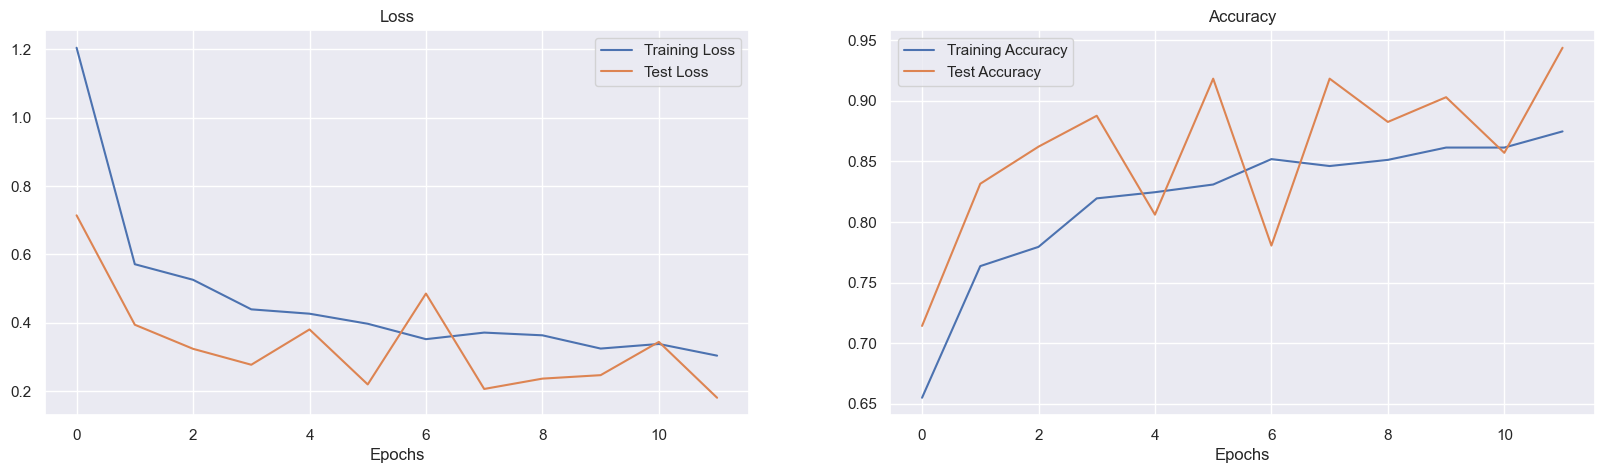

In [27]:
from keras.optimizers import RMSprop
from keras import Model
from keras.applications import VGG16
from keras import layers

resnet_pretrain_model = VGG16(input_shape = (224, 224, 3),
                              include_top = False,
                              weights = "imagenet")
for layer in resnet_pretrain_model.layers:
     layer.trainable = False

last_layer = resnet_pretrain_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

resnet_model = Model(resnet_pretrain_model.input, x)

resnet_model.compile(optimizer = RMSprop(lr=0.0001),
                     loss = 'sparse_categorical_crossentropy',
                     metrics = ['accuracy'])

history=resnet_model.fit(train_data_augmented,
                         epochs=12,
                         steps_per_epoch=len(train_data_augmented),
                         validation_data=val_data,
                         validation_steps=len(val_data))
plot_loss_curves(history)

Au bout de 3 epochs, l'apprentissage se stabilise. Malgré ça, dû à la complexité des modèles pré-entrainés, le temps par epoch est beaucoup plus long.
Par contre, en termes de résultats, on se rapproche des 95% de validité.


# Transfer Learning
On va tester les poids COCO de YOLOv3 sur une photo de la rue

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Model
net = cv2.dnn.readNetFromDarknet('yolo/yolov3.cfg', 'yolo/yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

## On recupere la liste de tous les objets detectables
objects_list = open('yolo/coco.names').read().strip().split('\n')

## Parametres
pm = 0.5  # proba min pour les prédictions
td = 0.3  # seuil pour le "non maximum suppression"

# Recuperation des couches YOLO du CNN
layers_yolo = [net.getLayerNames()[i-1] for i in net.getUnconnectedOutLayers()]

## Image

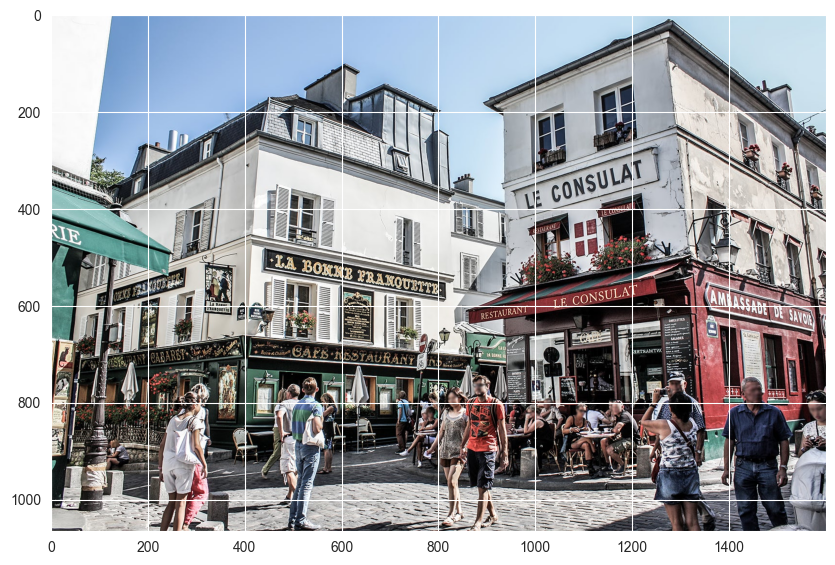

In [3]:
image_input = cv2.imread('yolo/rue.jpg')
image_input_shape = image_input.shape
h_dim = image_input.shape[0]
w_dim = image_input.shape[1]
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

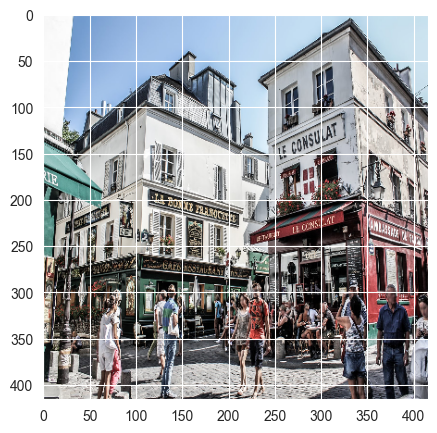

In [4]:
## Construction du blob
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)
blob_img = blob[0, :, :, :].transpose(1, 2, 0)
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_img)
plt.show()

## Calcul

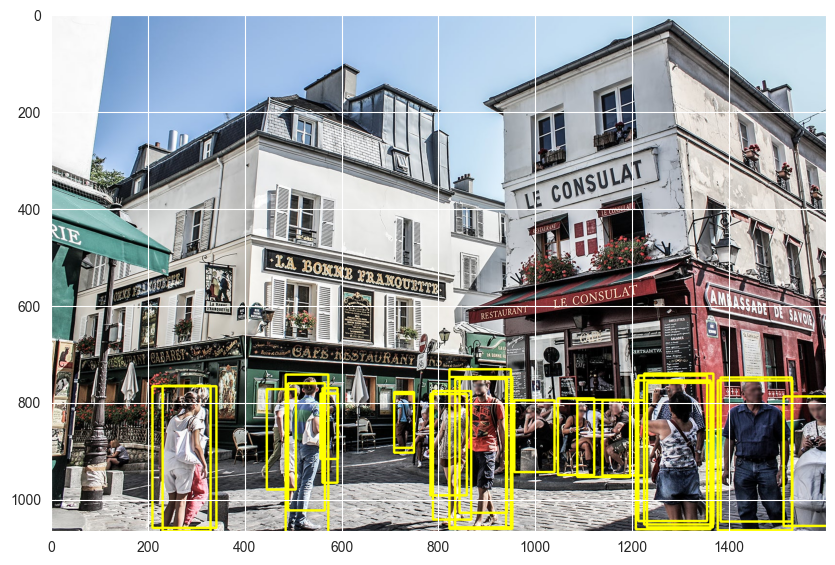

In [5]:
net.setInput(blob)
output = net.forward(layers_yolo)

##Generation des couleurs
colours = np.random.randint(0, 255, size=(len(objects_list), 3), dtype='uint8')

# Initialise les listes des sorties
bounding_boxes = []
confidences = []
classes = []

# Extrait les sorties du modèle
i = 0
for result in output:
    for detection in result:
        # Extrait la classe de l'objet et le score de confiance associé
        scores = detection[5:]
        clas = np.argmax(scores)
        confid = scores[clas]
        if confid > pm:
            # adapte les "bounding box" à la taille initiale de l'image
            box = detection[0:4] * np.array([w_dim, h_dim, w_dim, h_dim])
            x_center, y_center, box_width, box_height = box.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))
            # ajout aux listes des sorties
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confid))
            classes.append(clas)
        i += 1

## On affiche toutes les bounding-boxes sur l'image
for bounding_boxe in bounding_boxes:
    x_min, y_min = bounding_boxe[0], bounding_boxe[1]
    box_width, box_height = bounding_boxe[2], bounding_boxe[3]
    cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height), (0, 255, 255), 3)
    %matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

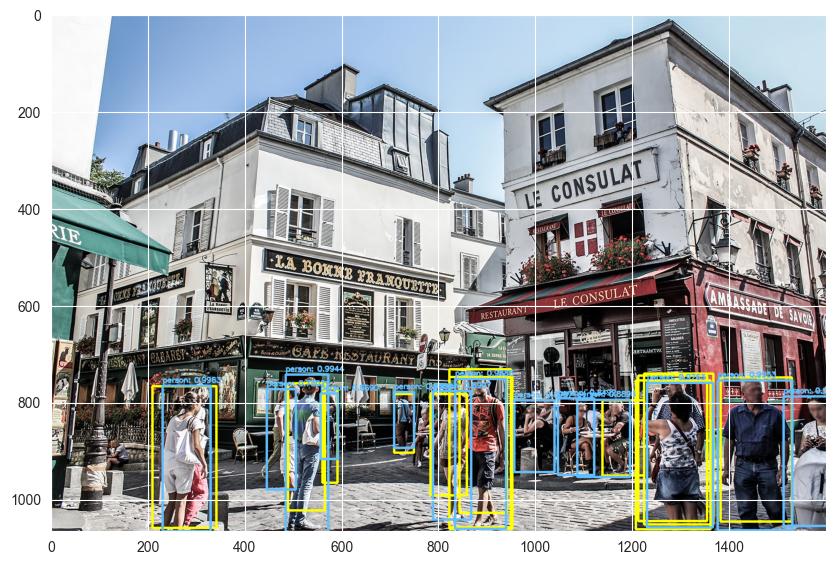

In [6]:
## Non maximum suppression(elimination par seuillage)
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, pm, td)

## On affiche les bounding-boxes sur l'image
if len(results) > 0:
    for i in results.flatten():
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
        colour_box = [int(j) for j in colours[classes[i]]]
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height), colour_box, 3)
        text_box = '{}: {:.4f}'.format(objects_list[int(classes[i])], confidences[i])
        cv2.putText(image_input, text_box, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,0.5, colour_box, 2)
        %matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

## Quelles sont les différences entre la version v3 et les suivantes v4, v5, v6 et v7 ?

### YOLOv4
YOLOv4, sorti en 2020, améliore les capacités déjà présentes sur YOLOv3. Le modèle permet une
meilleure précision tout en réduisant les coups d’utilisation avec une vitesse d’exécution temps réelle
sur un seul GPU.

Pour mettre en place ces améliorations, ses créateurs ont à la fois changer certaines parties de
l’architecture présente sur YOLOv3 et ont utilisé des nouvelles techniques d’optimisation. Ils ont par
exemple utilisé des nouvelles méthodes d’augmentation du jeu de données comme les mosaïques
d’images, qui consiste à regrouper quatre images, ce qui apprend au modèle à trouver des objets plus
petits et à prêter moins d'attention aux scènes environnantes qui ne sont pas immédiatement autour
de l'objet.

Ils ont aussi fait le choix de s’appuyer sur un « backbone » CSPDarknet53, un réseau contenant 29
couches de convolution avec des filtres 3x3 et 27.6 millions de paramètres.

![](img/yolo4.PNG)

Ces changements ont permis d’augmenter la précision de 11% sur le défi COCO Object Detection. La
vitesse d’exécution est aussi plus rapide de 12% comparée à YOLO v3.

![](img/yolo4_1.PNG)

### YOLOv5
YOLOv5 n’est pas une version supérieure à YOLOv4 mais une amélioration de YOLOv3 proposée par
d’autres personnes que celles qui ont sorti YOLOv4. De ce fait les améliorations apportées sont
sensiblement les mêmes que dans YOLOv4 (le modèle utilise aussi CSPDarknet53 par exemple).
YOLOv5, par rapport aux autres versions, est la première version de YOLO à être implémentée sur
Pytorch, plutôt que sur Darknet.

### YOLOv6
YOLOv6 a été créé afin de répondre à des besoins d’applications industrielles. Le but était d’avoir une
conception efficace adaptée aux matériels afin d’obtenir des performances élevées. Il a été publié par
Meituan, une entreprise chinoise de commerce électronique.

Cette nouvelle version, écrite en Pytorch, n’est pas considérée comme une version officielle de YOLO
mais a reçu le nom de YOLOv6 car elle s’inspire de l'architecture originale YOLO.

YOLOv6 a introduit quelques améliorations significatives par rapport à YOLOv5 : une conception de
backbone (EfficientRep backbone) et de neck (Rep-PAN Neck) adaptée au matériel et une tête
découplée.

![](img/yolo6_1.PNG)

YOLOv6 obtient de meilleurs résultats sur la base COCO que les versions précédentes

![](img/yolo6_2.PNG)

### YOLOv7
YOLOv7, sorti en juillet 2022, est la dernière version officielle en date. La performance est nettement
meilleure que dans les versions précédentes et cela vient principalement d’un changement
d’architecture.

YOLOv7 met en place le Compound Model Scaling. Cela permet de mettre à l'échelle un modèle en
ajustant les attributs clés du modèle pour générer des modèles qui répondent aux besoins de
différentes applications. La mise à l'échelle du modèle peut permettre d’optimiser la largeur (nombre
de canaux) ou la résolution (taille de l'image d'entrée) du modèle.

![](img/yolo7_1.PNG)

YOLOv7 permet d'améliorer considérablement la précision de la détection d'objets en temps réel sans
augmenter les coûts d'inférence. D’après des tests, YOLOv7 utilise 40 % de paramètres en moins que
d’autres modèles de détection d’objet. Par conséquent, YOLOv7 est moins couteux en matériel que
d’autres modèles d'apprentissage profond.

![](img/yolo7_2.PNG)

Références :
[https://viso.ai/deep-learning/yolov7-guide/](https://viso.ai/deep-learning/yolov7-guide/)
[https://towardsdatascience.com/yolo-v4-or-yolo-v5-or-pp-yolo-dad8e40f7109](https://towardsdatascience.com/yolo-v4-or-yolo-v5-or-pp-yolo-dad8e40f7109)
[https://blog.roboflow.com/yolov6/](https://blog.roboflow.com/yolov6/)
[https://medium.com/scalian/comment-fonctionne-yolov4-la-vitesse-et-la-pr%C3%A9cision-maximale-en-d%C3%A9tection-dobjet-43724ab8786](https://medium.com/scalian/comment-fonctionne-yolov4-la-vitesse-et-la-pr%C3%A9cision-maximale-en-d%C3%A9tection-dobjet-43724ab8786)
[https://blog.roboflow.com/guide-to-yolo-models/](https://blog.roboflow.com/guide-to-yolo-models/)

# Training
On va ici utiliser un dataset déjà préparé qui va contenir des images de gens avec et sans masques
Le programme permettant de train le YOLO (v5 ici) vient aussi de GitHUB

In [1]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

In [1]:
!git clone https://github.com/ultralytics/yolov5
!git clone https://github.com/sergiovirahonda/FaceMaskDataset

Cloning into 'FaceMaskDataset'...
Updating files:  17% (1649/9557)
Updating files:  18% (1721/9557)
Updating files:  19% (1816/9557)
Updating files:  20% (1912/9557)
Updating files:  21% (2007/9557)
Updating files:  22% (2103/9557)
Updating files:  23% (2199/9557)
Updating files:  24% (2294/9557)
Updating files:  25% (2390/9557)
Updating files:  26% (2485/9557)
Updating files:  27% (2581/9557)
Updating files:  28% (2676/9557)
Updating files:  29% (2772/9557)
Updating files:  30% (2868/9557)
Updating files:  31% (2963/9557)
Updating files:  32% (3059/9557)
Updating files:  32% (3098/9557)
Updating files:  33% (3154/9557)
Updating files:  34% (3250/9557)
Updating files:  35% (3345/9557)
Updating files:  36% (3441/9557)
Updating files:  37% (3537/9557)
Updating files:  38% (3632/9557)
Updating files:  39% (3728/9557)
Updating files:  40% (3823/9557)
Updating files:  41% (3919/9557)
Updating files:  41% (3931/9557)
Updating files:  42% (4014/9557)
Updating files:  43% (4110/9557)
Updating 

In [1]:
%cd yolov5

C:\var\TransferLearning\yolov5


In [2]:
!pip install -r requirements.txt

  Using cached matplotlib-3.6.2-cp310-cp310-win_amd64.whl (7.2 MB)
  Using cached numpy-1.23.4-cp310-cp310-win_amd64.whl (14.6 MB)
  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
  Using cached Pillow-9.3.0-cp310-cp310-win_amd64.whl (2.5 MB)
  Using cached PyYAML-6.0-cp310-cp310-win_amd64.whl (151 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached scipy-1.9.3-cp310-cp310-win_amd64.whl (40.1 MB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Using cached torch-1.13.0-cp310-cp310-win_amd64.whl (167.3 MB)
  Using cached torchvision-0.14.0-cp310-cp310-win_amd64.whl (1.1 MB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached pandas-1.5.1-cp310-cp310-win_amd64.whl (10.4 MB)
  Using cached seaborn-0.12.1-py3-none-any.whl (288 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached contourpy-1.0.6-cp310-cp310-win_amd64.whl (163 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)

You should consider upgrading via the 'C:\var\TransferLearning\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
!python train.py --img 415 --data dataset.yaml --epochs 2 --weights yolov5n.pt  --batch-size 128 --device 0

^C


Cette partie a été exécutée sur Google Collab car elle ne fonctionnait pas sur l'ordinateur pour une raison inconnue. Les poids ont ensuite été téléchargé et
ajouté à la suite du projet

In [2]:
!python detect.py --weights best_m.pt --img 640 --conf 0.25 --source masques.mp4

detect: weights=['best_m.pt'], source=masques.mp4, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v6.2-239-gf33718f Python-3.10.2 torch-1.13.0+cu116 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
video 1/1 (1/4947) C:\var\TransferLearning\yolov5\masques.mp4: 384x640 1 face mask, 15.0ms
video 1/1 (2/4947) C:\var\TransferLearning\yolov5\masques.mp4: 384x640 1 face mask, 10.0ms
video 1/1 (3/4947) C:\var\TransferLearning\yolov5\masques.mp4: 384x640 1 face mask, 10.0ms
video 1/1 (4/4947) C:\var\TransferLearning\yolov5\masques.mp4: 384x640 1 face mask, 9.5

#### Résultat
Le résultat final de la vidéo est disponible [ICI](https://www.youtube.com/watch?v=Ir9jBY0Oxg8)